In [7]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
torch.set_default_dtype(torch.float64)

In [8]:
def f(x, y, z, w):
    return -x**4+200*x+y**4-200*y-z**4+200*z-w**4+200*w

num_of_samples = 20
x_data = np.float64(np.linspace(-5, 5, num_of_samples))
y_data = np.float64(np.linspace(-5, 5, num_of_samples))
z_data = np.float64(np.linspace(-5, 5, num_of_samples))
w_data = np.float64(np.linspace(-5, 5, num_of_samples))

X, Y, Z, W = np.meshgrid(x_data, y_data, z_data, w_data)
outs = f(X, Y, Z, W)

In [9]:
dataset = Dataset(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1), W.reshape(-1, 1)), axis=1), outs.reshape(-1, 1))
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

activation = nn.Sigmoid()

In [10]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x

model = ELM(4, 100, 1)

In [11]:
V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].T)
H = torch.concatenate([torch.ones(1, len(trainset)), V], dim=0).T
T = trainset[:][1].reshape(1, -1).T
W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

Train error: 23888.87779119744
Test error: 24251.10197082627


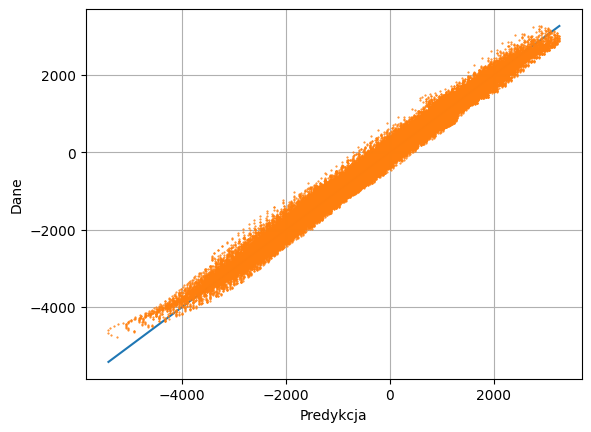

In [12]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 4))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 4))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
plt.plot([np.min(outs), np.max(outs)], [np.min(outs), np.max(outs)])
plt.plot(outs.reshape(-1), model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1), torch.Tensor(Z).reshape(-1, 1), torch.Tensor(W).reshape(-1, 1)), axis=1)).detach().numpy().reshape(-1), '.', markersize=1)
plt.xlabel('Predykcja')
plt.ylabel('Dane')
plt.grid()
plt.show()